In [1]:
# Imports 
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformer_models import *
from transformer_data import *

In [2]:
#Features we want right now: min f0, max f0, and mean f0 and maybe rms (not sure exactly what that is but was used in the paper)
path = '/home/CREMA-D/AudioWAV/'
files = os.listdir(path)

summary = pd.read_csv('/home/CREMA-D/processedResults/summaryTable.csv')

num_files = len(os.listdir(path)) #not sure how you want to count files
count = 0

# Aim to get to 12 features
num_features = 6

# Keep track of min and max duration of all data
min_dur = np.inf
max_dur = 0
max_length = 0

X = np.zeros((num_files, num_features))
Y = np.zeros(num_files).astype(str)
for sample in tqdm(files): #depends on how you access
    file = os.path.join(path,sample)
    current_wav, current_sr = librosa.load(file) #fix for set up 
    f0_series = librosa.yin(current_wav, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
    rms_series = librosa.feature.rms(y=current_wav)
    f0_max = np.amax(f0_series)
    f0_min = np.amin(f0_series)
    # Get f0 range
    f0_range = f0_max - f0_min
    # duration
    duration = librosa.get_duration(y=current_wav, sr=current_sr)
    
    # Outer duration
    if duration > max_dur:
        max_dur = duration
    if duration < min_dur:
        min_dur = duration
        
    # Get the pitches
#     pitches, magnitudes = librosa.piptrack(y=current_wav, sr=current_sr)
#     pitch_max = np.amax(pitches)
#     pitch_min = np.amin(pitches)
#     # Get f0 range
#     pitch_range = pitch_max - pitch_min
#     pitch_mean = np.mean(pitches)
    
    f0_mean = np.mean(f0_series)
    rms_max = np.amax(rms_series)
    rms_min = np.amin(rms_series)
    rms_mean = np.mean(rms_series)
#     x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean, pitch_max, pitch_min, 
#                   pitch_range, pitch_mean])
    if num_features == 8:
        x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean])
    else:
        x = np.array([f0_min, f0_max, f0_mean, rms_min, rms_max, rms_mean])
    X[count,:] = x
    # Get the label for VoiceVote
    info = summary.loc[summary['FileName'] == sample.split('.')[0]]
    try:
        Y[count] = info['VoiceVote'].values[0]
    except Exception as ex:
        print(f'info: {info}')
        print(f'index count: {count}')
        index = count
        print(f'unable to find file: {sample}')
        count -= 1
    count += 1
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')

 39%|███▉      | 2913/7442 [08:53<15:21,  4.92it/s]

info: Empty DataFrame
Columns: [Unnamed: 0, FileName, VoiceVote, VoiceLevel, FaceVote, FaceLevel, MultiModalVote, MultiModalLevel]
Index: []
index count: 2912
unable to find file: 1040_ITH_SAD_X.wav


100%|██████████| 7442/7442 [22:50<00:00,  5.43it/s]

shape of train data: (7442, 6)
shape of labels: (7442,)


In [3]:
#For Logistic Regression, can use sklearn.linear_model.LogisticRegression
# !pip install -U scikit-learn
# import sklearn
# from sklearn.linear_model import LogisticRegression
# Remove the file that wasn't in results
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')
print(Y[7440:])

# Remove that one example without a label
X = np.delete(X,-1,axis=0)
Y = Y[:-1]
print(f'New X shape: {X.shape}')
print(f'New Y shape: {Y.shape}')
print(f'Example feature: {X[4,:]}')
print(f'Last Y to check: {Y[-1]}')
print(f'min duration: {min_dur}')
print(f'max duration: {max_dur}')

# Find number of unique labels
num_unique = np.unique(Y).shape[0]
print(f'num classes: {num_unique}')

# Use label encoder for string labels
le = preprocessing.LabelEncoder()
le.fit(Y)
print(f'classes: {le.classes_}')
transformed_labels = le.transform(Y)
print(f'shape of transformed labels: {transformed_labels.shape}')

shape of train data: (7442, 6)
shape of labels: (7442,)
['N' '0.0']
New X shape: (7441, 6)
New Y shape: (7441,)
Example feature: [7.25388728e+01 2.79622457e+02 1.54880632e+02 4.40623751e-03
 5.49128167e-02 1.39149548e-02]
Last Y to check: N
min duration: 1.2679818594104308
max duration: 5.005034013605442
num classes: 39
classes: ['A' 'A:D' 'A:D:F:N' 'A:D:F:N:S' 'A:D:H:N' 'A:D:N' 'A:D:N:S' 'A:F' 'A:F:N'
 'A:H' 'A:H:N' 'A:N' 'A:N:S' 'A:S' 'D' 'D:F' 'D:F:H:N' 'D:F:N' 'D:F:N:S'
 'D:F:S' 'D:H' 'D:H:N' 'D:N' 'D:N:S' 'D:S' 'F' 'F:H' 'F:H:N' 'F:H:N:S'
 'F:N' 'F:N:S' 'F:S' 'H' 'H:N' 'H:N:S' 'H:S' 'N' 'N:S' 'S']
shape of transformed labels: (7441,)


In [4]:
# Create dataset from the data
class CREMADataset(Dataset):
    """
    CREMA-D dataset to load and use
    """
    def __init__(self, X, Y, num_examples, split='train', train_ratio = 0.8, val_ratio = 0.1):
        super().__init__()
        # X are the features, Y are the labels
        self.Y = Y  
        self.X = X
        self.num_examples = num_examples
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio

        # Decides which indices belong to which split.
        train_indices, val_indices, test_indices = self.split_data(num_examples, train_ratio=train_ratio, val_ratio=val_ratio)

        if split == 'train':
            indices = train_indices
        elif split == 'val':
            indices = val_indices
        elif split == 'test':
            indices = test_indices
        else:
            raise Exception(f'Split {split} not supported.')
            
        self.indices = indices

    def split_data(self, num_examples, train_ratio = 0.8, val_ratio = 0.1):
        """Splits data into train, val, and test sets based on speaker. When 
        evaluating methods on the test split, we measure how well they generalize
        to new (unseen) speakers.

        Concretely, this stores and returns indices belonging to each split.
        """
        # Fix seed so everyone reproduces the same splits.
        rs = np.random.RandomState(42)

        indices = np.arange(0, num_examples)
        train_idx = int(num_examples * train_ratio)
        num_remaining = num_examples - train_idx
        val_idx = train_idx + int(num_remaining/2)
        
        print(f'train idx: {train_idx}')
        print(f'val idx: {val_idx}')
        
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        test_indices = indices[val_idx:]
        return train_indices, val_indices, test_indices

    def __getitem__(self, index):
        index = self.indices[index]
        return torch.FloatTensor(self.X[index,:]), torch.LongTensor([self.Y[index]])

    def __len__(self):
        """Returns total number of utterances in the dataset."""
        return len(self.indices)


In [5]:
# Define the transformer
class MLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        # Initialize layers
        self.linear = nn.Linear(input_dim, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        output = self.linear(x)
        result = self.relu(output)
        return result
    
class EmotionTransformerPrototype(nn.Module):
    def __init__(self, input_dim, num_class, num_layers=2, hidden_dim=128):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = MLP(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
    def forward(self, inputs):
        log_probs = None
        # Hint: This is an N-way classification problem.
        embed = self.encoder(inputs)
        output = self.decoder(embed)
        # Softmax for N-way classification, followed by log to make them log_probs
        # log_probs = F.log_softmax(output, dim=2)
        log_probs = F.log_softmax(output, dim=-1)
        # If log softmax --> use negative log likelihood loss
        # If normal probabilities --> use normal cross entropy (equivalent methods!)
        return log_probs
  
    def get_loss(self, probs, targets):
        loss = None
        # Cross entropy loss if probs is normal probabilities
        # Negative log likelihood if probs is log probs
        # probs = probs.view(-1)
        # targets = targets.view(-1).type(dtype=torch.float) # --> float()
        # loss = F.cross_entropy(probs, targets)
        loss = F.nll_loss(probs, targets)
        return loss

class EmotionCNNTransformer(nn.Module):
    def __init__(
          self, input_dim, num_class, kernel_size, num_layers=2, hidden_dim=128, stride=1, padding=0):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.Conv1d(input_dim, hidden_dim, kernel_size, stride=stride, padding=padding)
        self.decoder = nn.Linear(hidden_dim, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    
class EmotionRNNTransformer(nn.Module):
    """
  Encoder-Decoder model to classify emotions for utterances.

  Args:
    input_dim: integer
                number of input features
    num_class: integer
                number of class labels
    num_layers: integer (default: 2)
                number of layers in encoder LSTM
    hidden_dim: integer (default: 128)
                number of hidden dimensions for encoder LSTM
    bidirectional: boolean (default: True)
                    is the encoder LSTM bidirectional?
  """
    def __init__(
          self, input_dim, num_class, num_layers=2, hidden_dim=128,
          bidirectional=True):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                                bidirectional=bidirectional, batch_first=True)
        self.decoder = nn.Linear(hidden_dim * 2, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = hidden_dim * num_layers * 2 * \
                              (2 if bidirectional else 1)

    def combine_h_and_c(self, h, c):
        """Combine the signals from RNN hidden and cell states."""
        batch_size = h.size(1)
        h = h.permute(1, 0, 2).contiguous()
        c = c.permute(1, 0, 2).contiguous()
        h = h.view(batch_size, -1)
        c = c.view(batch_size, -1)
        return torch.cat([h, c], dim=1)  # just concatenate

    def forward(self, inputs, input_lengths):
        batch_size, max_length, _ = inputs.size()
        # `torch.nn.utils.rnn.pack_padded_sequence` collapses padded sequences
        # to a contiguous chunk
        inputs = torch.nn.utils.rnn.pack_padded_sequence(
            inputs, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        log_probs = None
        h, c = None, None
        ############################ START OF YOUR CODE ############################
        # TODO(2.1)
        # Hint:
        # - Refer to https://pytorch.org/docs/stable/nn.html
        # - Use `self.encoder` to get the encodings output which is of shape
        #   (batch_size, max_length, num_directions*hidden_dim) and the
        #   hidden states and cell states which are both of shape
        #   (batch_size, num_layers*num_directions, hidden_dim)
        # - Pad outputs with `0.` using `torch.nn.utils.rnn.pad_packed_sequence`
        #   (turn on batch_first and set total_length as max_length).
        # - Apply 50% dropout.
        # - Use `self.decoder` to take the embeddings sequence and return
        #   probabilities for each character.
        # - Make sure to then convert to log probabilities.

        # Get encodings
        encodings, (h, c) = self.encoder(inputs)

        # Pad outputs with '0'
        padded, lengths = torch.nn.utils.rnn.pad_packed_sequence(encodings, batch_first=True, total_length=max_length)

        # Apply dropout
        dropout = nn.Dropout(p=0.5)
        dropped_padded = dropout(padded)

        # Decode to get probabilies dimensions (batch_size, time steps, num chars <vocab>)
        probabilities = self.decoder(dropped_padded)

        # Log probabilities
        # dim=2 because softmax over the vocabulary dimension. dim=1 is over time steps
        log_probs = F.log_softmax(probabilities, dim=2)

        ############################# END OF YOUR CODE #############################

        # The extracted embedding is not used for the ASR task but will be
        # needed for other auxiliary tasks.
        embedding = self.combine_h_and_c(h, c)
        return log_probs, embedding

    def get_loss(self, log_probs, targets):
            # cross-entropy for softmax/negative log likelihood loss for log softmax
        return F.nll_loss(probs, targets)

    def decode(self, log_probs, input_lengths, labels, label_lengths):
        # Use greedy decoding.
        decoded = torch.argmax(log_probs, dim=2)
        batch_size = decoded.size(0)

        hypothesis_lengths = input_lengths.cpu().numpy().tolist()
        if labels is None: # Run at inference time.
          references, reference_lengths = None, None
        else:
          references = labels.cpu().numpy().tolist()
          reference_lengths = label_lengths.cpu().numpy().tolist()

        return hypotheses, hypothesis_lengths, references, reference_lengths

In [4]:
# Set up the dataloaders
train_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='train')
val_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='val')
test_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='test')

# Check dataset length
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# Check data
print(train_dataset[0])
print(test_dataset[0])

# Set dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
5952
744
745
(tensor([6.8573e+01, 2.7087e+02, 1.8743e+02, 3.4345e-03, 1.8924e-02, 8.0639e-03]), tensor([36]))
(tensor([6.8139e+01, 7.0053e+02, 2.0496e+02, 3.7657e-03, 8.5794e-02, 2.4723e-02]), tensor([36]))


In [5]:
# Set up the model
run = 3
lr = 1e-3
weight_decay = 1e-5
num_layers = 5
model = EmotionTransformerPrototypeMLP(num_features, num_unique, num_layers=num_layers).cuda()
criterion = nn.NLLLoss()
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# start training
losses = []
val_loss = []
accuracies = []
val_accuracy = []

epochs = 300
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0
    correct_count = 0
    for x,y in train_loader:
        optim.zero_grad()
        
        x_cuda = x.cuda()
        y_cuda = torch.squeeze(y).cuda()
        
        # Output from mode
        output = model(x_cuda)
        output = output.cuda()
        
        # Calculate loss
        loss = criterion(output, y_cuda)
        
        # Calculate predictions
        # Need to take max over the log probs (batch_size, num_classes)
        _, pred = torch.max(output, 1)
        pred = pred.type(torch.FloatTensor).cuda()
        
        num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
        correct_count += num_correct
        
        # Backprop
        loss.backward()
        
        # Update weights
        optim.step()
        
        # Keep track of losses
        running_loss += loss.item()
    # Calculate average loss
    epoch_loss = running_loss / len(train_loader)
    
    # Accuracy
    accuracy = correct_count / (len(train_loader) * batch_size)
    
    losses.append(epoch_loss)
    accuracies.append(accuracy)
    print("Epoch %d - Training loss: %.3f , Training Accuracy: %.3f" %
          (epoch, epoch_loss, accuracy))
    
    # Validation every 10 epochs
    if epoch % 5 == 0:
        model.eval()
        correct_eval = 0
        eval_loss = 0
        for x,y in val_loader:
            x_cuda = x.cuda()
            y_cuda = torch.squeeze(y).cuda()
            
            # Output from mode
            output = model(x_cuda)
            output = output.cuda()
            # Loss
            loss = criterion(output, y_cuda)
            
            # Need to take max over the log probs (batch_size, num_classes)
            _, pred = torch.max(output, 1)
            pred = pred.type(torch.FloatTensor).cuda()
        
            num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
            correct_eval += num_correct
            eval_loss += loss.item()
        # Calculate average loss
        epoch_loss = eval_loss / len(val_loader)
        val_loss.append(epoch_loss)
    
        # Accuracy
        accuracy = correct_eval / (len(val_loader) * batch_size)
        val_accuracy.append(accuracy)
        print("Epoch %d - Validation loss: %.3f , Validation Accuracy: %.3f" %
          (epoch, epoch_loss, accuracy))


  0%|          | 1/300 [00:03<16:11,  3.25s/it]

Epoch 0 - Training loss: 2.089 , Training Accuracy: 0.503
Epoch 0 - Validation loss: 2.104 , Validation Accuracy: 0.499


  1%|          | 2/300 [00:06<15:29,  3.12s/it]

Epoch 1 - Training loss: 1.909 , Training Accuracy: 0.525


  1%|          | 3/300 [00:09<15:24,  3.11s/it]

Epoch 2 - Training loss: 1.867 , Training Accuracy: 0.523


  1%|▏         | 4/300 [00:12<15:17,  3.10s/it]

Epoch 3 - Training loss: 1.839 , Training Accuracy: 0.533


  2%|▏         | 5/300 [00:15<15:15,  3.10s/it]

Epoch 4 - Training loss: 1.828 , Training Accuracy: 0.541


  2%|▏         | 6/300 [00:18<15:20,  3.13s/it]

Epoch 5 - Training loss: 1.820 , Training Accuracy: 0.540
Epoch 5 - Validation loss: 1.837 , Validation Accuracy: 0.527


  2%|▏         | 7/300 [00:21<15:09,  3.11s/it]

Epoch 6 - Training loss: 1.810 , Training Accuracy: 0.546


  3%|▎         | 8/300 [00:24<15:01,  3.09s/it]

Epoch 7 - Training loss: 1.812 , Training Accuracy: 0.548


  3%|▎         | 9/300 [00:27<14:15,  2.94s/it]

Epoch 8 - Training loss: 1.803 , Training Accuracy: 0.549


  3%|▎         | 10/300 [00:29<12:14,  2.53s/it]

Epoch 9 - Training loss: 1.803 , Training Accuracy: 0.542


  4%|▎         | 11/300 [00:30<10:58,  2.28s/it]

Epoch 10 - Training loss: 1.797 , Training Accuracy: 0.550
Epoch 10 - Validation loss: 1.850 , Validation Accuracy: 0.505


  4%|▍         | 12/300 [00:32<09:58,  2.08s/it]

Epoch 11 - Training loss: 1.791 , Training Accuracy: 0.547


  4%|▍         | 13/300 [00:34<09:16,  1.94s/it]

Epoch 12 - Training loss: 1.789 , Training Accuracy: 0.545


  5%|▍         | 14/300 [00:35<08:46,  1.84s/it]

Epoch 13 - Training loss: 1.791 , Training Accuracy: 0.551


  5%|▌         | 15/300 [00:37<08:23,  1.77s/it]

Epoch 14 - Training loss: 1.786 , Training Accuracy: 0.545


  5%|▌         | 16/300 [00:38<08:17,  1.75s/it]

Epoch 15 - Training loss: 1.782 , Training Accuracy: 0.550
Epoch 15 - Validation loss: 1.851 , Validation Accuracy: 0.535


  6%|▌         | 17/300 [00:40<08:07,  1.72s/it]

Epoch 16 - Training loss: 1.775 , Training Accuracy: 0.547


  6%|▌         | 18/300 [00:42<07:57,  1.69s/it]

Epoch 17 - Training loss: 1.772 , Training Accuracy: 0.549


  6%|▋         | 19/300 [00:43<07:46,  1.66s/it]

Epoch 18 - Training loss: 1.777 , Training Accuracy: 0.551


  7%|▋         | 20/300 [00:45<07:39,  1.64s/it]

Epoch 19 - Training loss: 1.773 , Training Accuracy: 0.551


  7%|▋         | 21/300 [00:47<07:44,  1.66s/it]

Epoch 20 - Training loss: 1.773 , Training Accuracy: 0.549
Epoch 20 - Validation loss: 1.833 , Validation Accuracy: 0.539


  7%|▋         | 22/300 [00:48<07:40,  1.66s/it]

Epoch 21 - Training loss: 1.766 , Training Accuracy: 0.546


  8%|▊         | 23/300 [00:50<07:35,  1.64s/it]

Epoch 22 - Training loss: 1.762 , Training Accuracy: 0.552


  8%|▊         | 24/300 [00:52<07:33,  1.64s/it]

Epoch 23 - Training loss: 1.769 , Training Accuracy: 0.552


  8%|▊         | 25/300 [00:53<07:34,  1.65s/it]

Epoch 24 - Training loss: 1.768 , Training Accuracy: 0.555


  9%|▊         | 26/300 [00:55<07:39,  1.68s/it]

Epoch 25 - Training loss: 1.762 , Training Accuracy: 0.552
Epoch 25 - Validation loss: 1.813 , Validation Accuracy: 0.539


  9%|▉         | 27/300 [00:57<07:34,  1.67s/it]

Epoch 26 - Training loss: 1.761 , Training Accuracy: 0.552


  9%|▉         | 28/300 [00:59<07:57,  1.75s/it]

Epoch 27 - Training loss: 1.763 , Training Accuracy: 0.552


 10%|▉         | 29/300 [01:00<07:45,  1.72s/it]

Epoch 28 - Training loss: 1.758 , Training Accuracy: 0.555


 10%|█         | 30/300 [01:02<07:37,  1.69s/it]

Epoch 29 - Training loss: 1.761 , Training Accuracy: 0.551


 10%|█         | 31/300 [01:03<07:33,  1.69s/it]

Epoch 30 - Training loss: 1.762 , Training Accuracy: 0.554
Epoch 30 - Validation loss: 1.834 , Validation Accuracy: 0.531


 11%|█         | 32/300 [01:05<07:24,  1.66s/it]

Epoch 31 - Training loss: 1.756 , Training Accuracy: 0.553


 11%|█         | 33/300 [01:07<07:19,  1.65s/it]

Epoch 32 - Training loss: 1.755 , Training Accuracy: 0.550


 11%|█▏        | 34/300 [01:08<07:15,  1.64s/it]

Epoch 33 - Training loss: 1.761 , Training Accuracy: 0.554


 12%|█▏        | 35/300 [01:10<07:11,  1.63s/it]

Epoch 34 - Training loss: 1.752 , Training Accuracy: 0.557


 12%|█▏        | 36/300 [01:12<07:14,  1.64s/it]

Epoch 35 - Training loss: 1.759 , Training Accuracy: 0.554
Epoch 35 - Validation loss: 1.823 , Validation Accuracy: 0.533


 12%|█▏        | 37/300 [01:13<07:09,  1.63s/it]

Epoch 36 - Training loss: 1.759 , Training Accuracy: 0.551


 13%|█▎        | 38/300 [01:15<07:05,  1.62s/it]

Epoch 37 - Training loss: 1.757 , Training Accuracy: 0.555


 13%|█▎        | 39/300 [01:16<07:02,  1.62s/it]

Epoch 38 - Training loss: 1.754 , Training Accuracy: 0.558


 13%|█▎        | 40/300 [01:18<07:01,  1.62s/it]

Epoch 39 - Training loss: 1.752 , Training Accuracy: 0.556


 14%|█▎        | 41/300 [01:20<07:05,  1.64s/it]

Epoch 40 - Training loss: 1.759 , Training Accuracy: 0.554
Epoch 40 - Validation loss: 1.818 , Validation Accuracy: 0.543


 14%|█▍        | 42/300 [01:21<07:01,  1.63s/it]

Epoch 41 - Training loss: 1.754 , Training Accuracy: 0.556


 14%|█▍        | 43/300 [01:23<07:00,  1.64s/it]

Epoch 42 - Training loss: 1.755 , Training Accuracy: 0.552


 15%|█▍        | 44/300 [01:25<06:54,  1.62s/it]

Epoch 43 - Training loss: 1.753 , Training Accuracy: 0.556


 15%|█▌        | 45/300 [01:26<06:52,  1.62s/it]

Epoch 44 - Training loss: 1.752 , Training Accuracy: 0.555


 15%|█▌        | 46/300 [01:28<06:57,  1.64s/it]

Epoch 45 - Training loss: 1.749 , Training Accuracy: 0.560
Epoch 45 - Validation loss: 1.821 , Validation Accuracy: 0.524


 16%|█▌        | 47/300 [01:29<06:52,  1.63s/it]

Epoch 46 - Training loss: 1.753 , Training Accuracy: 0.555


 16%|█▌        | 48/300 [01:31<06:50,  1.63s/it]

Epoch 47 - Training loss: 1.748 , Training Accuracy: 0.556


 16%|█▋        | 49/300 [01:33<06:46,  1.62s/it]

Epoch 48 - Training loss: 1.752 , Training Accuracy: 0.554


 17%|█▋        | 50/300 [01:34<06:43,  1.61s/it]

Epoch 49 - Training loss: 1.750 , Training Accuracy: 0.554


 17%|█▋        | 51/300 [01:36<06:46,  1.63s/it]

Epoch 50 - Training loss: 1.745 , Training Accuracy: 0.562
Epoch 50 - Validation loss: 1.814 , Validation Accuracy: 0.545


 17%|█▋        | 52/300 [01:38<06:41,  1.62s/it]

Epoch 51 - Training loss: 1.748 , Training Accuracy: 0.556


 18%|█▊        | 53/300 [01:39<06:40,  1.62s/it]

Epoch 52 - Training loss: 1.751 , Training Accuracy: 0.555


 18%|█▊        | 54/300 [01:41<06:37,  1.62s/it]

Epoch 53 - Training loss: 1.746 , Training Accuracy: 0.557


 18%|█▊        | 55/300 [01:42<06:35,  1.62s/it]

Epoch 54 - Training loss: 1.743 , Training Accuracy: 0.560


 19%|█▊        | 56/300 [01:44<06:40,  1.64s/it]

Epoch 55 - Training loss: 1.741 , Training Accuracy: 0.561
Epoch 55 - Validation loss: 1.845 , Validation Accuracy: 0.532


 19%|█▉        | 57/300 [01:46<06:36,  1.63s/it]

Epoch 56 - Training loss: 1.744 , Training Accuracy: 0.560


 19%|█▉        | 58/300 [01:47<06:31,  1.62s/it]

Epoch 57 - Training loss: 1.745 , Training Accuracy: 0.557


 20%|█▉        | 59/300 [01:49<06:26,  1.61s/it]

Epoch 58 - Training loss: 1.741 , Training Accuracy: 0.558


 20%|██        | 60/300 [01:51<06:27,  1.61s/it]

Epoch 59 - Training loss: 1.746 , Training Accuracy: 0.556


 20%|██        | 61/300 [01:52<06:32,  1.64s/it]

Epoch 60 - Training loss: 1.740 , Training Accuracy: 0.561
Epoch 60 - Validation loss: 1.827 , Validation Accuracy: 0.532


 21%|██        | 62/300 [01:54<06:29,  1.64s/it]

Epoch 61 - Training loss: 1.737 , Training Accuracy: 0.560


 21%|██        | 63/300 [01:55<06:25,  1.63s/it]

Epoch 62 - Training loss: 1.743 , Training Accuracy: 0.559


 21%|██▏       | 64/300 [01:57<06:23,  1.62s/it]

Epoch 63 - Training loss: 1.740 , Training Accuracy: 0.562


 22%|██▏       | 65/300 [01:59<06:23,  1.63s/it]

Epoch 64 - Training loss: 1.740 , Training Accuracy: 0.559


 22%|██▏       | 66/300 [02:00<06:26,  1.65s/it]

Epoch 65 - Training loss: 1.740 , Training Accuracy: 0.561
Epoch 65 - Validation loss: 1.812 , Validation Accuracy: 0.541


 22%|██▏       | 67/300 [02:02<06:25,  1.65s/it]

Epoch 66 - Training loss: 1.738 , Training Accuracy: 0.562


 23%|██▎       | 68/300 [02:04<06:23,  1.65s/it]

Epoch 67 - Training loss: 1.735 , Training Accuracy: 0.556


 23%|██▎       | 69/300 [02:05<06:20,  1.65s/it]

Epoch 68 - Training loss: 1.733 , Training Accuracy: 0.562


 23%|██▎       | 70/300 [02:07<06:18,  1.65s/it]

Epoch 69 - Training loss: 1.738 , Training Accuracy: 0.560


 24%|██▎       | 71/300 [02:09<06:22,  1.67s/it]

Epoch 70 - Training loss: 1.740 , Training Accuracy: 0.559
Epoch 70 - Validation loss: 1.832 , Validation Accuracy: 0.544


 24%|██▍       | 72/300 [02:10<06:16,  1.65s/it]

Epoch 71 - Training loss: 1.740 , Training Accuracy: 0.559


 24%|██▍       | 73/300 [02:12<06:13,  1.64s/it]

Epoch 72 - Training loss: 1.737 , Training Accuracy: 0.562


 25%|██▍       | 74/300 [02:14<06:10,  1.64s/it]

Epoch 73 - Training loss: 1.735 , Training Accuracy: 0.563


 25%|██▌       | 75/300 [02:15<06:06,  1.63s/it]

Epoch 74 - Training loss: 1.739 , Training Accuracy: 0.560


 25%|██▌       | 76/300 [02:17<06:10,  1.65s/it]

Epoch 75 - Training loss: 1.736 , Training Accuracy: 0.557
Epoch 75 - Validation loss: 1.824 , Validation Accuracy: 0.529


 26%|██▌       | 77/300 [02:19<06:04,  1.64s/it]

Epoch 76 - Training loss: 1.736 , Training Accuracy: 0.560


 26%|██▌       | 78/300 [02:20<06:01,  1.63s/it]

Epoch 77 - Training loss: 1.734 , Training Accuracy: 0.559


 26%|██▋       | 79/300 [02:22<06:01,  1.64s/it]

Epoch 78 - Training loss: 1.737 , Training Accuracy: 0.560


 27%|██▋       | 80/300 [02:23<05:59,  1.64s/it]

Epoch 79 - Training loss: 1.731 , Training Accuracy: 0.562


 27%|██▋       | 81/300 [02:25<06:06,  1.67s/it]

Epoch 80 - Training loss: 1.732 , Training Accuracy: 0.562
Epoch 80 - Validation loss: 1.818 , Validation Accuracy: 0.541


 27%|██▋       | 82/300 [02:27<06:14,  1.72s/it]

Epoch 81 - Training loss: 1.730 , Training Accuracy: 0.565


 28%|██▊       | 83/300 [02:29<06:17,  1.74s/it]

Epoch 82 - Training loss: 1.728 , Training Accuracy: 0.562


 28%|██▊       | 84/300 [02:30<06:06,  1.70s/it]

Epoch 83 - Training loss: 1.730 , Training Accuracy: 0.559


 28%|██▊       | 85/300 [02:32<06:01,  1.68s/it]

Epoch 84 - Training loss: 1.731 , Training Accuracy: 0.566


 29%|██▊       | 86/300 [02:34<06:01,  1.69s/it]

Epoch 85 - Training loss: 1.727 , Training Accuracy: 0.561
Epoch 85 - Validation loss: 1.818 , Validation Accuracy: 0.541


 29%|██▉       | 87/300 [02:35<05:54,  1.67s/it]

Epoch 86 - Training loss: 1.730 , Training Accuracy: 0.561


 29%|██▉       | 88/300 [02:37<05:50,  1.65s/it]

Epoch 87 - Training loss: 1.732 , Training Accuracy: 0.564


 30%|██▉       | 89/300 [02:39<05:54,  1.68s/it]

Epoch 88 - Training loss: 1.729 , Training Accuracy: 0.562


 30%|███       | 90/300 [02:40<05:48,  1.66s/it]

Epoch 89 - Training loss: 1.733 , Training Accuracy: 0.563


 30%|███       | 91/300 [02:42<05:51,  1.68s/it]

Epoch 90 - Training loss: 1.727 , Training Accuracy: 0.563
Epoch 90 - Validation loss: 1.803 , Validation Accuracy: 0.548


 31%|███       | 92/300 [02:44<05:45,  1.66s/it]

Epoch 91 - Training loss: 1.728 , Training Accuracy: 0.565


 31%|███       | 93/300 [02:45<05:39,  1.64s/it]

Epoch 92 - Training loss: 1.736 , Training Accuracy: 0.562


 31%|███▏      | 94/300 [02:47<05:36,  1.63s/it]

Epoch 93 - Training loss: 1.734 , Training Accuracy: 0.563


 32%|███▏      | 95/300 [02:48<05:32,  1.62s/it]

Epoch 94 - Training loss: 1.732 , Training Accuracy: 0.564


 32%|███▏      | 96/300 [02:50<05:34,  1.64s/it]

Epoch 95 - Training loss: 1.728 , Training Accuracy: 0.568
Epoch 95 - Validation loss: 1.805 , Validation Accuracy: 0.543


 32%|███▏      | 97/300 [02:52<05:30,  1.63s/it]

Epoch 96 - Training loss: 1.729 , Training Accuracy: 0.562


 33%|███▎      | 98/300 [02:53<05:29,  1.63s/it]

Epoch 97 - Training loss: 1.725 , Training Accuracy: 0.564


 33%|███▎      | 99/300 [02:55<05:27,  1.63s/it]

Epoch 98 - Training loss: 1.726 , Training Accuracy: 0.566


 33%|███▎      | 100/300 [02:57<05:25,  1.63s/it]

Epoch 99 - Training loss: 1.727 , Training Accuracy: 0.565


 34%|███▎      | 101/300 [02:58<05:29,  1.66s/it]

Epoch 100 - Training loss: 1.717 , Training Accuracy: 0.566
Epoch 100 - Validation loss: 1.806 , Validation Accuracy: 0.548


 34%|███▍      | 102/300 [03:00<05:26,  1.65s/it]

Epoch 101 - Training loss: 1.727 , Training Accuracy: 0.564


 34%|███▍      | 103/300 [03:02<05:22,  1.64s/it]

Epoch 102 - Training loss: 1.719 , Training Accuracy: 0.568


 35%|███▍      | 104/300 [03:03<05:20,  1.64s/it]

Epoch 103 - Training loss: 1.721 , Training Accuracy: 0.566


 35%|███▌      | 105/300 [03:05<05:17,  1.63s/it]

Epoch 104 - Training loss: 1.721 , Training Accuracy: 0.568


 35%|███▌      | 106/300 [03:07<05:22,  1.66s/it]

Epoch 105 - Training loss: 1.722 , Training Accuracy: 0.568
Epoch 105 - Validation loss: 1.794 , Validation Accuracy: 0.551


 36%|███▌      | 107/300 [03:08<05:18,  1.65s/it]

Epoch 106 - Training loss: 1.716 , Training Accuracy: 0.567


 36%|███▌      | 108/300 [03:10<05:15,  1.64s/it]

Epoch 107 - Training loss: 1.717 , Training Accuracy: 0.567


 36%|███▋      | 109/300 [03:11<05:11,  1.63s/it]

Epoch 108 - Training loss: 1.721 , Training Accuracy: 0.566


 37%|███▋      | 110/300 [03:13<05:11,  1.64s/it]

Epoch 109 - Training loss: 1.718 , Training Accuracy: 0.572


 37%|███▋      | 111/300 [03:15<05:13,  1.66s/it]

Epoch 110 - Training loss: 1.720 , Training Accuracy: 0.567
Epoch 110 - Validation loss: 1.802 , Validation Accuracy: 0.545


 37%|███▋      | 112/300 [03:16<05:08,  1.64s/it]

Epoch 111 - Training loss: 1.731 , Training Accuracy: 0.566


 38%|███▊      | 113/300 [03:18<05:04,  1.63s/it]

Epoch 112 - Training loss: 1.717 , Training Accuracy: 0.569


 38%|███▊      | 114/300 [03:20<05:01,  1.62s/it]

Epoch 113 - Training loss: 1.720 , Training Accuracy: 0.568


 38%|███▊      | 115/300 [03:21<05:00,  1.62s/it]

Epoch 114 - Training loss: 1.717 , Training Accuracy: 0.571


 39%|███▊      | 116/300 [03:23<05:03,  1.65s/it]

Epoch 115 - Training loss: 1.721 , Training Accuracy: 0.570
Epoch 115 - Validation loss: 1.835 , Validation Accuracy: 0.555


 39%|███▉      | 117/300 [03:25<04:59,  1.64s/it]

Epoch 116 - Training loss: 1.711 , Training Accuracy: 0.571


 39%|███▉      | 118/300 [03:26<04:57,  1.63s/it]

Epoch 117 - Training loss: 1.719 , Training Accuracy: 0.568


 40%|███▉      | 119/300 [03:28<04:54,  1.63s/it]

Epoch 118 - Training loss: 1.712 , Training Accuracy: 0.571


 40%|████      | 120/300 [03:29<04:52,  1.63s/it]

Epoch 119 - Training loss: 1.714 , Training Accuracy: 0.567


 40%|████      | 121/300 [03:31<04:56,  1.66s/it]

Epoch 120 - Training loss: 1.714 , Training Accuracy: 0.569
Epoch 120 - Validation loss: 1.781 , Validation Accuracy: 0.557


 41%|████      | 122/300 [03:33<04:53,  1.65s/it]

Epoch 121 - Training loss: 1.708 , Training Accuracy: 0.571


 41%|████      | 123/300 [03:34<04:51,  1.65s/it]

Epoch 122 - Training loss: 1.711 , Training Accuracy: 0.572


 41%|████▏     | 124/300 [03:36<04:48,  1.64s/it]

Epoch 123 - Training loss: 1.706 , Training Accuracy: 0.571


 42%|████▏     | 125/300 [03:38<04:45,  1.63s/it]

Epoch 124 - Training loss: 1.708 , Training Accuracy: 0.574


 42%|████▏     | 126/300 [03:39<04:50,  1.67s/it]

Epoch 125 - Training loss: 1.715 , Training Accuracy: 0.572
Epoch 125 - Validation loss: 1.769 , Validation Accuracy: 0.570


 42%|████▏     | 127/300 [03:41<04:47,  1.66s/it]

Epoch 126 - Training loss: 1.712 , Training Accuracy: 0.572


 43%|████▎     | 128/300 [03:43<04:44,  1.65s/it]

Epoch 127 - Training loss: 1.704 , Training Accuracy: 0.576


 43%|████▎     | 129/300 [03:44<04:41,  1.64s/it]

Epoch 128 - Training loss: 1.702 , Training Accuracy: 0.570


 43%|████▎     | 130/300 [03:46<04:38,  1.64s/it]

Epoch 129 - Training loss: 1.700 , Training Accuracy: 0.576


 44%|████▎     | 131/300 [03:48<04:41,  1.66s/it]

Epoch 130 - Training loss: 1.707 , Training Accuracy: 0.571
Epoch 130 - Validation loss: 1.775 , Validation Accuracy: 0.570


 44%|████▍     | 132/300 [03:49<04:37,  1.65s/it]

Epoch 131 - Training loss: 1.693 , Training Accuracy: 0.578


 44%|████▍     | 133/300 [03:51<04:34,  1.64s/it]

Epoch 132 - Training loss: 1.701 , Training Accuracy: 0.575


 45%|████▍     | 134/300 [03:53<04:32,  1.64s/it]

Epoch 133 - Training loss: 1.700 , Training Accuracy: 0.576


 45%|████▌     | 135/300 [03:54<04:30,  1.64s/it]

Epoch 134 - Training loss: 1.702 , Training Accuracy: 0.577


 45%|████▌     | 136/300 [03:56<04:31,  1.66s/it]

Epoch 135 - Training loss: 1.696 , Training Accuracy: 0.581
Epoch 135 - Validation loss: 1.756 , Validation Accuracy: 0.568


 46%|████▌     | 137/300 [03:58<04:45,  1.75s/it]

Epoch 136 - Training loss: 1.689 , Training Accuracy: 0.582


 46%|████▌     | 138/300 [03:59<04:37,  1.71s/it]

Epoch 137 - Training loss: 1.719 , Training Accuracy: 0.576


 46%|████▋     | 139/300 [04:01<04:32,  1.69s/it]

Epoch 138 - Training loss: 1.696 , Training Accuracy: 0.578


 47%|████▋     | 140/300 [04:03<04:28,  1.68s/it]

Epoch 139 - Training loss: 1.682 , Training Accuracy: 0.585


 47%|████▋     | 141/300 [04:04<04:28,  1.69s/it]

Epoch 140 - Training loss: 1.695 , Training Accuracy: 0.579
Epoch 140 - Validation loss: 1.752 , Validation Accuracy: 0.569


 47%|████▋     | 142/300 [04:06<04:23,  1.67s/it]

Epoch 141 - Training loss: 1.688 , Training Accuracy: 0.580


 48%|████▊     | 143/300 [04:08<04:20,  1.66s/it]

Epoch 142 - Training loss: 1.681 , Training Accuracy: 0.583


 48%|████▊     | 144/300 [04:09<04:16,  1.65s/it]

Epoch 143 - Training loss: 1.689 , Training Accuracy: 0.584


 48%|████▊     | 145/300 [04:11<04:14,  1.64s/it]

Epoch 144 - Training loss: 1.677 , Training Accuracy: 0.588


 49%|████▊     | 146/300 [04:13<04:16,  1.67s/it]

Epoch 145 - Training loss: 1.684 , Training Accuracy: 0.587
Epoch 145 - Validation loss: 1.789 , Validation Accuracy: 0.555


 49%|████▉     | 147/300 [04:14<04:13,  1.66s/it]

Epoch 146 - Training loss: 1.690 , Training Accuracy: 0.582


 49%|████▉     | 148/300 [04:16<04:10,  1.65s/it]

Epoch 147 - Training loss: 1.676 , Training Accuracy: 0.585


 50%|████▉     | 149/300 [04:18<04:08,  1.64s/it]

Epoch 148 - Training loss: 1.674 , Training Accuracy: 0.588


 50%|█████     | 150/300 [04:19<04:06,  1.64s/it]

Epoch 149 - Training loss: 1.674 , Training Accuracy: 0.586


 50%|█████     | 151/300 [04:21<04:07,  1.66s/it]

Epoch 150 - Training loss: 1.683 , Training Accuracy: 0.583
Epoch 150 - Validation loss: 1.780 , Validation Accuracy: 0.559


 51%|█████     | 152/300 [04:23<04:04,  1.65s/it]

Epoch 151 - Training loss: 1.677 , Training Accuracy: 0.588


 51%|█████     | 153/300 [04:24<04:01,  1.64s/it]

Epoch 152 - Training loss: 1.675 , Training Accuracy: 0.589


 51%|█████▏    | 154/300 [04:26<03:58,  1.63s/it]

Epoch 153 - Training loss: 1.673 , Training Accuracy: 0.588


 52%|█████▏    | 155/300 [04:27<03:56,  1.63s/it]

Epoch 154 - Training loss: 1.676 , Training Accuracy: 0.585


 52%|█████▏    | 156/300 [04:29<03:57,  1.65s/it]

Epoch 155 - Training loss: 1.669 , Training Accuracy: 0.591
Epoch 155 - Validation loss: 1.781 , Validation Accuracy: 0.561


 52%|█████▏    | 157/300 [04:31<03:54,  1.64s/it]

Epoch 156 - Training loss: 1.670 , Training Accuracy: 0.589


 53%|█████▎    | 158/300 [04:32<03:53,  1.64s/it]

Epoch 157 - Training loss: 1.668 , Training Accuracy: 0.585


 53%|█████▎    | 159/300 [04:34<03:51,  1.64s/it]

Epoch 158 - Training loss: 1.670 , Training Accuracy: 0.588


 53%|█████▎    | 160/300 [04:36<03:48,  1.63s/it]

Epoch 159 - Training loss: 1.676 , Training Accuracy: 0.585


 54%|█████▎    | 161/300 [04:37<03:49,  1.65s/it]

Epoch 160 - Training loss: 1.670 , Training Accuracy: 0.590
Epoch 160 - Validation loss: 1.750 , Validation Accuracy: 0.566


 54%|█████▍    | 162/300 [04:39<03:53,  1.69s/it]

Epoch 161 - Training loss: 1.663 , Training Accuracy: 0.591


 54%|█████▍    | 163/300 [04:41<03:50,  1.68s/it]

Epoch 162 - Training loss: 1.679 , Training Accuracy: 0.586


 55%|█████▍    | 164/300 [04:42<03:47,  1.67s/it]

Epoch 163 - Training loss: 1.668 , Training Accuracy: 0.590


 55%|█████▌    | 165/300 [04:44<03:43,  1.66s/it]

Epoch 164 - Training loss: 1.673 , Training Accuracy: 0.587


 55%|█████▌    | 166/300 [04:46<03:43,  1.67s/it]

Epoch 165 - Training loss: 1.665 , Training Accuracy: 0.593
Epoch 165 - Validation loss: 1.735 , Validation Accuracy: 0.577


 56%|█████▌    | 167/300 [04:47<03:40,  1.66s/it]

Epoch 166 - Training loss: 1.663 , Training Accuracy: 0.594


 56%|█████▌    | 168/300 [04:49<03:36,  1.64s/it]

Epoch 167 - Training loss: 1.674 , Training Accuracy: 0.586


 56%|█████▋    | 169/300 [04:51<03:32,  1.62s/it]

Epoch 168 - Training loss: 1.672 , Training Accuracy: 0.585


 57%|█████▋    | 170/300 [04:52<03:29,  1.61s/it]

Epoch 169 - Training loss: 1.676 , Training Accuracy: 0.587


 57%|█████▋    | 171/300 [04:54<03:31,  1.64s/it]

Epoch 170 - Training loss: 1.676 , Training Accuracy: 0.587
Epoch 170 - Validation loss: 1.745 , Validation Accuracy: 0.572


 57%|█████▋    | 172/300 [04:55<03:28,  1.63s/it]

Epoch 171 - Training loss: 1.666 , Training Accuracy: 0.593


 58%|█████▊    | 173/300 [04:57<03:26,  1.63s/it]

Epoch 172 - Training loss: 1.671 , Training Accuracy: 0.588


 58%|█████▊    | 174/300 [04:59<03:23,  1.61s/it]

Epoch 173 - Training loss: 1.661 , Training Accuracy: 0.589


 58%|█████▊    | 175/300 [05:00<03:20,  1.60s/it]

Epoch 174 - Training loss: 1.660 , Training Accuracy: 0.592


 59%|█████▊    | 176/300 [05:02<03:22,  1.63s/it]

Epoch 175 - Training loss: 1.675 , Training Accuracy: 0.587
Epoch 175 - Validation loss: 1.729 , Validation Accuracy: 0.574


 59%|█████▉    | 177/300 [05:04<03:19,  1.62s/it]

Epoch 176 - Training loss: 1.673 , Training Accuracy: 0.588


 59%|█████▉    | 178/300 [05:05<03:17,  1.62s/it]

Epoch 177 - Training loss: 1.669 , Training Accuracy: 0.589


 60%|█████▉    | 179/300 [05:07<03:15,  1.62s/it]

Epoch 178 - Training loss: 1.671 , Training Accuracy: 0.584


 60%|██████    | 180/300 [05:08<03:13,  1.62s/it]

Epoch 179 - Training loss: 1.663 , Training Accuracy: 0.593


 60%|██████    | 181/300 [05:10<03:14,  1.64s/it]

Epoch 180 - Training loss: 1.658 , Training Accuracy: 0.593
Epoch 180 - Validation loss: 1.762 , Validation Accuracy: 0.566


 61%|██████    | 182/300 [05:12<03:12,  1.63s/it]

Epoch 181 - Training loss: 1.667 , Training Accuracy: 0.589


 61%|██████    | 183/300 [05:13<03:10,  1.63s/it]

Epoch 182 - Training loss: 1.662 , Training Accuracy: 0.592


 61%|██████▏   | 184/300 [05:15<03:08,  1.62s/it]

Epoch 183 - Training loss: 1.680 , Training Accuracy: 0.585


 62%|██████▏   | 185/300 [05:17<03:06,  1.62s/it]

Epoch 184 - Training loss: 1.664 , Training Accuracy: 0.591


 62%|██████▏   | 186/300 [05:18<03:07,  1.65s/it]

Epoch 185 - Training loss: 1.673 , Training Accuracy: 0.584
Epoch 185 - Validation loss: 1.760 , Validation Accuracy: 0.576


 62%|██████▏   | 187/300 [05:20<03:05,  1.64s/it]

Epoch 186 - Training loss: 1.661 , Training Accuracy: 0.591


 63%|██████▎   | 188/300 [05:21<03:03,  1.63s/it]

Epoch 187 - Training loss: 1.665 , Training Accuracy: 0.590


 63%|██████▎   | 189/300 [05:23<03:01,  1.64s/it]

Epoch 188 - Training loss: 1.662 , Training Accuracy: 0.591


 63%|██████▎   | 190/300 [05:25<03:00,  1.64s/it]

Epoch 189 - Training loss: 1.664 , Training Accuracy: 0.591


 64%|██████▎   | 191/300 [05:26<03:02,  1.67s/it]

Epoch 190 - Training loss: 1.659 , Training Accuracy: 0.591
Epoch 190 - Validation loss: 1.753 , Validation Accuracy: 0.577


 64%|██████▍   | 192/300 [05:28<03:10,  1.76s/it]

Epoch 191 - Training loss: 1.661 , Training Accuracy: 0.590


 64%|██████▍   | 193/300 [05:30<03:04,  1.72s/it]

Epoch 192 - Training loss: 1.668 , Training Accuracy: 0.589


 65%|██████▍   | 194/300 [05:32<02:58,  1.69s/it]

Epoch 193 - Training loss: 1.661 , Training Accuracy: 0.592


 65%|██████▌   | 195/300 [05:33<02:55,  1.67s/it]

Epoch 194 - Training loss: 1.657 , Training Accuracy: 0.592


 65%|██████▌   | 196/300 [05:35<02:53,  1.67s/it]

Epoch 195 - Training loss: 1.657 , Training Accuracy: 0.594
Epoch 195 - Validation loss: 1.779 , Validation Accuracy: 0.556


 66%|██████▌   | 197/300 [05:37<02:49,  1.65s/it]

Epoch 196 - Training loss: 1.654 , Training Accuracy: 0.589


 66%|██████▌   | 198/300 [05:38<02:46,  1.63s/it]

Epoch 197 - Training loss: 1.665 , Training Accuracy: 0.589


 66%|██████▋   | 199/300 [05:40<02:44,  1.62s/it]

Epoch 198 - Training loss: 1.667 , Training Accuracy: 0.587


 67%|██████▋   | 200/300 [05:41<02:41,  1.62s/it]

Epoch 199 - Training loss: 1.663 , Training Accuracy: 0.589


 67%|██████▋   | 201/300 [05:43<02:41,  1.63s/it]

Epoch 200 - Training loss: 1.669 , Training Accuracy: 0.586
Epoch 200 - Validation loss: 1.755 , Validation Accuracy: 0.547


 67%|██████▋   | 202/300 [05:45<02:37,  1.61s/it]

Epoch 201 - Training loss: 1.655 , Training Accuracy: 0.591


 68%|██████▊   | 203/300 [05:46<02:36,  1.62s/it]

Epoch 202 - Training loss: 1.664 , Training Accuracy: 0.592


 68%|██████▊   | 204/300 [05:48<02:35,  1.62s/it]

Epoch 203 - Training loss: 1.661 , Training Accuracy: 0.591


 68%|██████▊   | 205/300 [05:49<02:32,  1.61s/it]

Epoch 204 - Training loss: 1.655 , Training Accuracy: 0.592


 69%|██████▊   | 206/300 [05:51<02:33,  1.63s/it]

Epoch 205 - Training loss: 1.661 , Training Accuracy: 0.590
Epoch 205 - Validation loss: 1.808 , Validation Accuracy: 0.557


 69%|██████▉   | 207/300 [05:53<02:31,  1.63s/it]

Epoch 206 - Training loss: 1.657 , Training Accuracy: 0.594


 69%|██████▉   | 208/300 [05:54<02:29,  1.62s/it]

Epoch 207 - Training loss: 1.662 , Training Accuracy: 0.592


 70%|██████▉   | 209/300 [05:56<02:26,  1.61s/it]

Epoch 208 - Training loss: 1.658 , Training Accuracy: 0.596


 70%|███████   | 210/300 [05:58<02:25,  1.61s/it]

Epoch 209 - Training loss: 1.661 , Training Accuracy: 0.590


 70%|███████   | 211/300 [05:59<02:27,  1.65s/it]

Epoch 210 - Training loss: 1.690 , Training Accuracy: 0.579
Epoch 210 - Validation loss: 1.735 , Validation Accuracy: 0.565


 71%|███████   | 212/300 [06:01<02:23,  1.64s/it]

Epoch 211 - Training loss: 1.658 , Training Accuracy: 0.592


 71%|███████   | 213/300 [06:03<02:22,  1.64s/it]

Epoch 212 - Training loss: 1.657 , Training Accuracy: 0.591


 71%|███████▏  | 214/300 [06:04<02:21,  1.64s/it]

Epoch 213 - Training loss: 1.655 , Training Accuracy: 0.592


 72%|███████▏  | 215/300 [06:06<02:19,  1.64s/it]

Epoch 214 - Training loss: 1.661 , Training Accuracy: 0.589


 72%|███████▏  | 216/300 [06:08<02:19,  1.66s/it]

Epoch 215 - Training loss: 1.653 , Training Accuracy: 0.592
Epoch 215 - Validation loss: 1.741 , Validation Accuracy: 0.566


 72%|███████▏  | 217/300 [06:09<02:17,  1.66s/it]

Epoch 216 - Training loss: 1.653 , Training Accuracy: 0.595


 73%|███████▎  | 218/300 [06:11<02:16,  1.66s/it]

Epoch 217 - Training loss: 1.643 , Training Accuracy: 0.598


 73%|███████▎  | 219/300 [06:13<02:13,  1.65s/it]

Epoch 218 - Training loss: 1.654 , Training Accuracy: 0.593


 73%|███████▎  | 220/300 [06:14<02:11,  1.64s/it]

Epoch 219 - Training loss: 1.659 , Training Accuracy: 0.590


 74%|███████▎  | 221/300 [06:16<02:11,  1.66s/it]

Epoch 220 - Training loss: 1.656 , Training Accuracy: 0.591
Epoch 220 - Validation loss: 1.765 , Validation Accuracy: 0.552


 74%|███████▍  | 222/300 [06:17<02:08,  1.65s/it]

Epoch 221 - Training loss: 1.658 , Training Accuracy: 0.590


 74%|███████▍  | 223/300 [06:19<02:06,  1.65s/it]

Epoch 222 - Training loss: 1.661 , Training Accuracy: 0.591


 75%|███████▍  | 224/300 [06:21<02:04,  1.63s/it]

Epoch 223 - Training loss: 1.667 , Training Accuracy: 0.592


 75%|███████▌  | 225/300 [06:22<02:01,  1.61s/it]

Epoch 224 - Training loss: 1.661 , Training Accuracy: 0.591


 75%|███████▌  | 226/300 [06:24<02:00,  1.63s/it]

Epoch 225 - Training loss: 1.652 , Training Accuracy: 0.593
Epoch 225 - Validation loss: 1.789 , Validation Accuracy: 0.553


 76%|███████▌  | 227/300 [06:26<01:57,  1.62s/it]

Epoch 226 - Training loss: 1.652 , Training Accuracy: 0.592


 76%|███████▌  | 228/300 [06:27<01:55,  1.61s/it]

Epoch 227 - Training loss: 1.653 , Training Accuracy: 0.592


 76%|███████▋  | 229/300 [06:29<01:54,  1.61s/it]

Epoch 228 - Training loss: 1.656 , Training Accuracy: 0.595


 77%|███████▋  | 230/300 [06:30<01:52,  1.61s/it]

Epoch 229 - Training loss: 1.663 , Training Accuracy: 0.588


 77%|███████▋  | 231/300 [06:32<01:53,  1.65s/it]

Epoch 230 - Training loss: 1.653 , Training Accuracy: 0.592
Epoch 230 - Validation loss: 1.775 , Validation Accuracy: 0.551


 77%|███████▋  | 232/300 [06:34<01:51,  1.64s/it]

Epoch 231 - Training loss: 1.652 , Training Accuracy: 0.592


 78%|███████▊  | 233/300 [06:35<01:49,  1.63s/it]

Epoch 232 - Training loss: 1.648 , Training Accuracy: 0.596


 78%|███████▊  | 234/300 [06:37<01:48,  1.64s/it]

Epoch 233 - Training loss: 1.650 , Training Accuracy: 0.594


 78%|███████▊  | 235/300 [06:39<01:50,  1.70s/it]

Epoch 234 - Training loss: 1.649 , Training Accuracy: 0.594


 79%|███████▊  | 236/300 [06:41<01:49,  1.71s/it]

Epoch 235 - Training loss: 1.658 , Training Accuracy: 0.591
Epoch 235 - Validation loss: 1.748 , Validation Accuracy: 0.572


 79%|███████▉  | 237/300 [06:42<01:45,  1.68s/it]

Epoch 236 - Training loss: 1.647 , Training Accuracy: 0.595


 79%|███████▉  | 238/300 [06:44<01:42,  1.65s/it]

Epoch 237 - Training loss: 1.645 , Training Accuracy: 0.596


 80%|███████▉  | 239/300 [06:45<01:39,  1.64s/it]

Epoch 238 - Training loss: 1.647 , Training Accuracy: 0.594


 80%|████████  | 240/300 [06:47<01:37,  1.62s/it]

Epoch 239 - Training loss: 1.644 , Training Accuracy: 0.594


 80%|████████  | 241/300 [06:49<01:36,  1.63s/it]

Epoch 240 - Training loss: 1.645 , Training Accuracy: 0.595
Epoch 240 - Validation loss: 1.823 , Validation Accuracy: 0.548


 81%|████████  | 242/300 [06:50<01:33,  1.62s/it]

Epoch 241 - Training loss: 1.658 , Training Accuracy: 0.591


 81%|████████  | 243/300 [06:52<01:31,  1.61s/it]

Epoch 242 - Training loss: 1.643 , Training Accuracy: 0.600


 81%|████████▏ | 244/300 [06:53<01:30,  1.62s/it]

Epoch 243 - Training loss: 1.645 , Training Accuracy: 0.598


 82%|████████▏ | 245/300 [06:55<01:28,  1.61s/it]

Epoch 244 - Training loss: 1.648 , Training Accuracy: 0.593


 82%|████████▏ | 246/300 [06:57<01:30,  1.68s/it]

Epoch 245 - Training loss: 1.645 , Training Accuracy: 0.598
Epoch 245 - Validation loss: 1.754 , Validation Accuracy: 0.568


 82%|████████▏ | 247/300 [06:59<01:31,  1.73s/it]

Epoch 246 - Training loss: 1.645 , Training Accuracy: 0.595


 83%|████████▎ | 248/300 [07:00<01:27,  1.68s/it]

Epoch 247 - Training loss: 1.646 , Training Accuracy: 0.594


 83%|████████▎ | 249/300 [07:02<01:24,  1.65s/it]

Epoch 248 - Training loss: 1.639 , Training Accuracy: 0.597


 83%|████████▎ | 250/300 [07:03<01:21,  1.63s/it]

Epoch 249 - Training loss: 1.638 , Training Accuracy: 0.596


 84%|████████▎ | 251/300 [07:05<01:21,  1.66s/it]

Epoch 250 - Training loss: 1.645 , Training Accuracy: 0.595
Epoch 250 - Validation loss: 1.783 , Validation Accuracy: 0.547


 84%|████████▍ | 252/300 [07:07<01:18,  1.64s/it]

Epoch 251 - Training loss: 1.644 , Training Accuracy: 0.594


 84%|████████▍ | 253/300 [07:08<01:16,  1.63s/it]

Epoch 252 - Training loss: 1.639 , Training Accuracy: 0.596


 85%|████████▍ | 254/300 [07:10<01:14,  1.63s/it]

Epoch 253 - Training loss: 1.656 , Training Accuracy: 0.592


 85%|████████▌ | 255/300 [07:12<01:13,  1.62s/it]

Epoch 254 - Training loss: 1.641 , Training Accuracy: 0.598


 85%|████████▌ | 256/300 [07:13<01:12,  1.66s/it]

Epoch 255 - Training loss: 1.654 , Training Accuracy: 0.595
Epoch 255 - Validation loss: 1.821 , Validation Accuracy: 0.556


 86%|████████▌ | 257/300 [07:15<01:10,  1.65s/it]

Epoch 256 - Training loss: 1.639 , Training Accuracy: 0.597


 86%|████████▌ | 258/300 [07:17<01:08,  1.64s/it]

Epoch 257 - Training loss: 1.648 , Training Accuracy: 0.596


 86%|████████▋ | 259/300 [07:18<01:06,  1.63s/it]

Epoch 258 - Training loss: 1.648 , Training Accuracy: 0.594


 87%|████████▋ | 260/300 [07:20<01:05,  1.63s/it]

Epoch 259 - Training loss: 1.645 , Training Accuracy: 0.598


 87%|████████▋ | 261/300 [07:22<01:04,  1.66s/it]

Epoch 260 - Training loss: 1.638 , Training Accuracy: 0.597
Epoch 260 - Validation loss: 1.757 , Validation Accuracy: 0.562


 87%|████████▋ | 262/300 [07:23<01:02,  1.64s/it]

Epoch 261 - Training loss: 1.649 , Training Accuracy: 0.592


 88%|████████▊ | 263/300 [07:25<01:00,  1.64s/it]

Epoch 262 - Training loss: 1.649 , Training Accuracy: 0.593


 88%|████████▊ | 264/300 [07:26<00:58,  1.63s/it]

Epoch 263 - Training loss: 1.647 , Training Accuracy: 0.592


 88%|████████▊ | 265/300 [07:28<00:56,  1.63s/it]

Epoch 264 - Training loss: 1.647 , Training Accuracy: 0.596


 89%|████████▊ | 266/300 [07:30<00:56,  1.65s/it]

Epoch 265 - Training loss: 1.640 , Training Accuracy: 0.596
Epoch 265 - Validation loss: 1.793 , Validation Accuracy: 0.561


 89%|████████▉ | 267/300 [07:31<00:53,  1.64s/it]

Epoch 266 - Training loss: 1.650 , Training Accuracy: 0.596


 89%|████████▉ | 268/300 [07:33<00:52,  1.63s/it]

Epoch 267 - Training loss: 1.662 , Training Accuracy: 0.594


 90%|████████▉ | 269/300 [07:35<00:50,  1.63s/it]

Epoch 268 - Training loss: 1.646 , Training Accuracy: 0.593


 90%|█████████ | 270/300 [07:36<00:48,  1.62s/it]

Epoch 269 - Training loss: 1.649 , Training Accuracy: 0.591


 90%|█████████ | 271/300 [07:38<00:47,  1.64s/it]

Epoch 270 - Training loss: 1.641 , Training Accuracy: 0.596
Epoch 270 - Validation loss: 1.789 , Validation Accuracy: 0.557


 91%|█████████ | 272/300 [07:39<00:45,  1.63s/it]

Epoch 271 - Training loss: 1.650 , Training Accuracy: 0.598


 91%|█████████ | 273/300 [07:41<00:43,  1.62s/it]

Epoch 272 - Training loss: 1.651 , Training Accuracy: 0.594


 91%|█████████▏| 274/300 [07:43<00:42,  1.63s/it]

Epoch 273 - Training loss: 1.640 , Training Accuracy: 0.595


 92%|█████████▏| 275/300 [07:44<00:41,  1.64s/it]

Epoch 274 - Training loss: 1.641 , Training Accuracy: 0.595


 92%|█████████▏| 276/300 [07:46<00:39,  1.66s/it]

Epoch 275 - Training loss: 1.645 , Training Accuracy: 0.593
Epoch 275 - Validation loss: 1.776 , Validation Accuracy: 0.549


 92%|█████████▏| 277/300 [07:48<00:37,  1.64s/it]

Epoch 276 - Training loss: 1.645 , Training Accuracy: 0.594


 93%|█████████▎| 278/300 [07:49<00:36,  1.64s/it]

Epoch 277 - Training loss: 1.645 , Training Accuracy: 0.592


 93%|█████████▎| 279/300 [07:51<00:34,  1.62s/it]

Epoch 278 - Training loss: 1.638 , Training Accuracy: 0.596


 93%|█████████▎| 280/300 [07:52<00:32,  1.62s/it]

Epoch 279 - Training loss: 1.649 , Training Accuracy: 0.594


 94%|█████████▎| 281/300 [07:54<00:31,  1.66s/it]

Epoch 280 - Training loss: 1.632 , Training Accuracy: 0.598
Epoch 280 - Validation loss: 1.752 , Validation Accuracy: 0.553


 94%|█████████▍| 282/300 [07:56<00:29,  1.65s/it]

Epoch 281 - Training loss: 1.631 , Training Accuracy: 0.600


 94%|█████████▍| 283/300 [07:57<00:27,  1.64s/it]

Epoch 282 - Training loss: 1.645 , Training Accuracy: 0.598


 95%|█████████▍| 284/300 [07:59<00:26,  1.63s/it]

Epoch 283 - Training loss: 1.647 , Training Accuracy: 0.598


 95%|█████████▌| 285/300 [08:01<00:24,  1.62s/it]

Epoch 284 - Training loss: 1.655 , Training Accuracy: 0.595


 95%|█████████▌| 286/300 [08:02<00:23,  1.65s/it]

Epoch 285 - Training loss: 1.650 , Training Accuracy: 0.590
Epoch 285 - Validation loss: 1.762 , Validation Accuracy: 0.572


 96%|█████████▌| 287/300 [08:04<00:21,  1.64s/it]

Epoch 286 - Training loss: 1.642 , Training Accuracy: 0.593


 96%|█████████▌| 288/300 [08:06<00:19,  1.62s/it]

Epoch 287 - Training loss: 1.645 , Training Accuracy: 0.593


 96%|█████████▋| 289/300 [08:07<00:17,  1.61s/it]

Epoch 288 - Training loss: 1.654 , Training Accuracy: 0.592


 97%|█████████▋| 290/300 [08:09<00:16,  1.61s/it]

Epoch 289 - Training loss: 1.646 , Training Accuracy: 0.597


 97%|█████████▋| 291/300 [08:10<00:14,  1.63s/it]

Epoch 290 - Training loss: 1.642 , Training Accuracy: 0.595
Epoch 290 - Validation loss: 1.768 , Validation Accuracy: 0.551


 97%|█████████▋| 292/300 [08:12<00:12,  1.62s/it]

Epoch 291 - Training loss: 1.641 , Training Accuracy: 0.597


 98%|█████████▊| 293/300 [08:14<00:11,  1.61s/it]

Epoch 292 - Training loss: 1.640 , Training Accuracy: 0.597


 98%|█████████▊| 294/300 [08:15<00:09,  1.61s/it]

Epoch 293 - Training loss: 1.646 , Training Accuracy: 0.594


 98%|█████████▊| 295/300 [08:17<00:08,  1.61s/it]

Epoch 294 - Training loss: 1.643 , Training Accuracy: 0.593


 99%|█████████▊| 296/300 [08:19<00:06,  1.64s/it]

Epoch 295 - Training loss: 1.651 , Training Accuracy: 0.594
Epoch 295 - Validation loss: 1.785 , Validation Accuracy: 0.568


 99%|█████████▉| 297/300 [08:20<00:04,  1.63s/it]

Epoch 296 - Training loss: 1.632 , Training Accuracy: 0.600


 99%|█████████▉| 298/300 [08:22<00:03,  1.62s/it]

Epoch 297 - Training loss: 1.640 , Training Accuracy: 0.595


100%|█████████▉| 299/300 [08:23<00:01,  1.62s/it]

Epoch 298 - Training loss: 1.646 , Training Accuracy: 0.592


100%|██████████| 300/300 [08:25<00:00,  1.69s/it]

Epoch 299 - Training loss: 1.646 , Training Accuracy: 0.595


Model: EmotionTransformerPrototypeMLP
Epochs:  300
Learning rate:  0.001
Weight decay:  1e-05
Num features: 6 


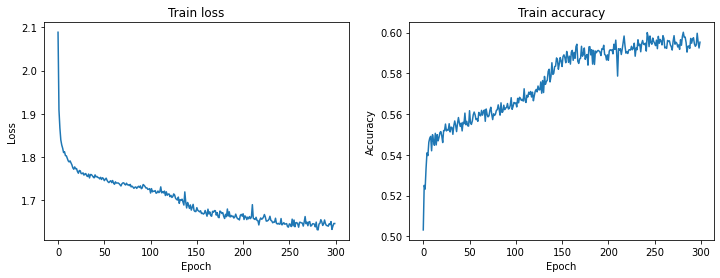

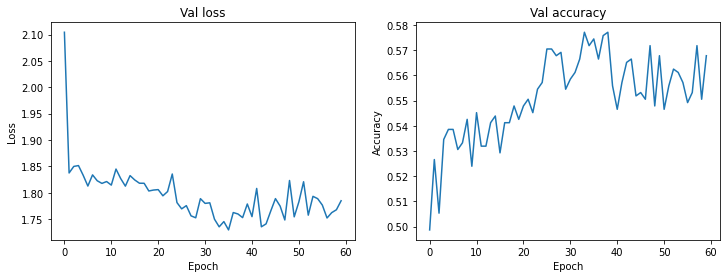

In [6]:
# Run info:
model_name = 'EmotionTransformerPrototypeMLP'
print(f'Model: {model_name}')
print(f'Epochs: ', epochs)
print(f'Learning rate: ', lr)
print(f'Weight decay: ', weight_decay)
print(f'Num features: {num_features} ')
path = f'./Results/{model_name}_{run}'
if not os.path.isdir(path):
    os.mkdir(path)
    
with open(path+'/hyperparameters.txt', 'w') as file:
    file.write(f'Model: {model_name} \n')
    file.write(f'Epochs: {epochs} \n')
    file.write(f'learning rate: {lr} \n')
    file.write(f'weight decay: {weight_decay} \n')
    file.write(f'Num features: {num_features} \n ')
    file.write(f'num layers: {num_layers} \n')

# Train plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(losses)
ax2.plot(accuracies)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Train loss')
ax2.set_title('Train accuracy')
plt.savefig(path+'/train_plots.png')
plt.show()

# Val plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(val_loss)
ax2.plot(val_accuracy)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Val loss')
ax2.set_title('Val accuracy')
plt.savefig(path+'/val_plots.png')
plt.show()

# Save the trained model
torch.save(model.state_dict(), path+'/'+model_name+'_state_dict.pt')

In [7]:
# Run testing on the results
model.eval()
correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
for x,y in test_loader:
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    output = model(x_cuda)
    output = output.cuda()
    
    # Loss
    loss = criterion(output, y_cuda)

    # Need to take max over the log probs (batch_size, num_classes)
    _, pred = torch.max(output, 1)
    pred = pred.type(torch.FloatTensor).cuda()

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    
    f1 = f1_score(y_cuda.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='macro')
    total_macro += f1
    f1 = f1_score(y_cuda.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='micro')
    total_micro += f1
    
    correct_test += num_correct
    test_loss += loss
# Calculate average loss
epoch_loss = test_loss / len(test_loader)

# Accuracy
accuracy = correct_test / (len(test_loader) * batch_size)
avg_macro = total_macro / len(test_loader)
avg_micro = total_micro / len(test_loader)
print("Test loss: %.3f , Test Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % 
      (epoch_loss, accuracy, avg_macro, avg_micro))

Test loss: 1.681 , Test Accuracy: 0.618, Avg F1 macro: 0.2635, Avg F1 micro: 0.624


In [8]:
# Save test result
with open(path+'/test_results.txt', 'w') as f:
    f.write("Test loss: %.3f , Test Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % 
      (epoch_loss, accuracy, avg_macro, avg_micro))

In [9]:
# Get data and labels for training
# train_split = int(0.8 * num_files)
# print('train_split: ', train_split)
# print(f'train size: {X[:train_split].shape}, val size: {X[train_split:].shape}')

# model = LogisticRegression().fit(X[:train_split], Y[:train_split])

# # Predict on validation/test (80-20 split)
# predictions = model.predict(X[train_split:])

# # Output score (mean accuracy)
# score = model.score(X[train_split:],Y[train_split:])
# print(f'Test accuracy score: {score}')

# f1 = f1_score(Y[train_split:], predictions, average='macro')
# print(f'macro f1 score: {f1}')
# f1 = f1_score(Y[train_split:], predictions, average='micro')
# print(f'micro f1 score: {f1}')

In [10]:
# Some basic stats for the dataset
# avg = np.mean(X, axis=0)
# print(f'avg shape: {avg.shape}')
# stats = ['f0_min', 'f0_max', 'f0_mean', 'f0_range', 'duration', 'rms_min', 'rms_max', 'rms_mean', 'pitch_max', 'pitch_min', 
#                   'pitch_range', 'pitch_mean']
# stats = ['f0_min', 'f0_max', 'f0_mean', 'f0_range', 'duration', 'rms_min', 'rms_max', 'rms_mean']
# for j,stat in enumerate(stats):
#     print(f'{stat} average: {avg[j]}')